# Data Sourcing and Cleaning

Compare and use for different premade datasets with currently sourced files to improve accuracy of results
with prelabeled Data

In [23]:
import os

import sys

cid = 'LocalSources/kerascvattentionmodelsmain'
assert(os.path.exists('LocalSources/kerascvattentionmodelsmain'))
if cid not in sys.path:
    sys.path.append(cid)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

import glob , os
import cv2
from PIL import Image, ImageDraw
print("Tensorflow Version ", tf.__version__)

from tqdm import tqdm
import math
import datetime
import collections

from IPython.display import clear_output
from tqdm import tqdm
from keras_cv_attention_models import coat as ct
from keras_cv_attention_models import backend
from keras_cv_attention_models.backend import layers

%load_ext tensorboard

Tensorflow Version  2.10.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
files = "C:\\Users\\Paulton\\Documents\\Transcoder_Own_Work\\LocalSources\\3_classes_shiba_oid_flickr"

In [25]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, thickness=4):
    image_pil = None
    
    if isinstance(image, np.ndarray):
        image_pil = Image.fromarray(np.uint8(image), mode = "RGB")
    elif isinstance(image, PIL.Image.Image):
        image_pil = image.copy()
    
    draw = ImageDraw.Draw(image_pil)
    im_width, im_height = image_pil.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)

    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], 
                width=thickness, 
                fill=(81,50,194,255))
    
    return np.asarray(image_pil)

In [26]:
DataSet = pd.read_csv("E:\\BBoutput_shiba.csv")
display(DataSet)

Class              filename  Height  Width  Channels     y_min  \
0     Lies_on_floor  0012d875044bfa35.jpg     576   1024         3  0.038194   
1     Lies_on_floor  0042a10234c156fb.jpg     768   1024         3  0.131510   
2     Lies_on_floor  007403de8b96f53b.jpg     768   1024         3  0.264323   
3     Lies_on_floor  00d9daa325a78faf.jpg     768   1024         3  0.139323   
4     Lies_on_floor  0109db3827301d30.jpg     768   1024         3  0.045573   
...             ...                   ...     ...    ...       ...       ...   
3862       Standing  feb1e44ba1fb95c1.jpg     753   1024         3  0.159363   
3863       Standing  fec100f73ce10a24.jpg     680   1024         3  0.104412   
3864       Standing  ffae623038c101f3.jpg    1024    768         3  0.194336   
3865       Standing  ffc6f3dfe464c70a.jpg     683   1024         3  0.209370   
3866       Standing  ffc7ab8a217d7680.jpg     724   1024         3  0.226519   

         x_min     y_max     x_max     score      area  
0     0.271484  0.854167  0.765625  0.901069  0.403205  
1     0.179688  0.988281  0.707031  0.931425  0.451813  
2     0.008789  0.747396  0.793945  0.881868  0.379288  
3     0.026367  0.795573  0.933594  0.861698  0.595367  
4     0.012695  0.675781  0.799805  0.921358  0.496043  
...        ...       ...       ...       ...       ...  
3862  0.129883  0.880478  0.829102  0.709695  0.504217  
3863  0.205078  0.951471  0.807617  0.903280  0.510386  
3864  0.244792  0.824219  0.720052  0.918532  0.299358  
3865  0.290039  0.877013  0.824219  0.905023  0.356641  
3866  0.362305  0.629834  0.940430  0.922997  0.233166  

[3867 rows x 11 columns]

In [27]:
fileList = ["LocalSources\\test-annotations-bbox.csv", 
            "E:\\oidv6-train-annotations-bbox.csv",
           "E:\\validation-annotations-bbox.csv"]
OID =  pd.concat((pd.read_csv(f) for f in fileList), ignore_index = True)


In [28]:
DataSet['filename'] = DataSet.apply(lambda row: row[1].replace('.jpg', ''), axis = 1)
test = OID.merge(DataSet, left_on='ImageID', right_on = 'filename', how='right')
DataSet['filename'] = DataSet.apply(lambda row: row[1] if '.jpg' in row[1] else f"{row[1]}.jpg", axis = 1)

#test = test[(test['LabelName'] == '/m/0bt9lr') |  (test['XMin'] == None)]
#display(OID)
display(test)
test.info()

ImageID    Source   LabelName  Confidence      XMin      XMax  \
0     0012d875044bfa35    xclick   /m/0bt9lr         1.0  0.288125  0.771250   
1     0042a10234c156fb    xclick   /m/0bt9lr         1.0  0.176875  0.708125   
2     0042a10234c156fb    xclick  /m/0h8n6f9         1.0  0.000000  0.999375   
3     007403de8b96f53b    xclick   /m/034c16         1.0  0.000000  0.195625   
4     007403de8b96f53b    xclick   /m/034c16         1.0  0.170000  0.354375   
...                ...       ...         ...         ...       ...       ...   
6546  fec100f73ce10a24    xclick   /m/0bt9lr         1.0  0.203877  0.807380   
6547  ffae623038c101f3  freeform   /m/0bt9lr         1.0  0.240981  0.718027   
6548  ffc6f3dfe464c70a  freeform   /m/0bt9lr         1.0  0.291048  0.824744   
6549  ffc7ab8a217d7680    xclick    /m/018xm         1.0  0.351875  0.388125   
6550  ffc7ab8a217d7680    xclick   /m/0bt9lr         1.0  0.351875  0.942500   

          YMin      YMax  IsOccluded  IsTruncated  ...          filename  \
0     0.068889  0.854444         0.0          0.0  ...  0012d875044bfa35   
1     0.130000  0.985833         1.0          0.0  ...  0042a10234c156fb   
2     0.203333  0.844167         1.0          1.0  ...  0042a10234c156fb   
3     0.131667  0.275833         1.0          1.0  ...  007403de8b96f53b   
4     0.105833  0.334167         1.0          0.0  ...  007403de8b96f53b   
...        ...       ...         ...          ...  ...               ...   
6546  0.104520  0.949153         1.0          0.0  ...  fec100f73ce10a24   
6547  0.196010  0.828790         0.0          0.0  ...  ffae623038c101f3   
6548  0.212195  0.880722         0.0          0.0  ...  ffc6f3dfe464c70a   
6549  0.564103  0.613616         0.0          0.0  ...  ffc7ab8a217d7680   
6550  0.221043  0.701149         1.0          1.0  ...  ffc7ab8a217d7680   

      Height  Width  Channels     y_min     x_min     y_max     x_max  \
0        576   1024         3  0.038194  0.271484  0.854167  0.765625   
1        768   1024         3  0.131510  0.179688  0.988281  0.707031   
2        768   1024         3  0.131510  0.179688  0.988281  0.707031   
3        768   1024         3  0.264323  0.008789  0.747396  0.793945   
4        768   1024         3  0.264323  0.008789  0.747396  0.793945   
...      ...    ...       ...       ...       ...       ...       ...   
6546     680   1024         3  0.104412  0.205078  0.951471  0.807617   
6547    1024    768         3  0.194336  0.244792  0.824219  0.720052   
6548     683   1024         3  0.209370  0.290039  0.877013  0.824219   
6549     724   1024         3  0.226519  0.362305  0.629834  0.940430   
6550     724   1024         3  0.226519  0.362305  0.629834  0.940430   

         score      area  
0     0.901069  0.403205  
1     0.931425  0.451813  
2     0.931425  0.451813  
3     0.881868  0.379288  
4     0.881868  0.379288  
...        ...       ...  
6546  0.903280  0.510386  
6547  0.918532  0.299358  
6548  0.905023  0.356641  
6549  0.922997  0.233166  
6550  0.922997  0.233166  

[6551 rows x 32 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6551 entries, 0 to 6550
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      4165 non-null   object 
 1   Source       4165 non-null   object 
 2   LabelName    4165 non-null   object 
 3   Confidence   4165 non-null   float64
 4   XMin         4165 non-null   float64
 5   XMax         4165 non-null   float64
 6   YMin         4165 non-null   float64
 7   YMax         4165 non-null   float64
 8   IsOccluded   4165 non-null   float64
 9   IsTruncated  4165 non-null   float64
 10  IsGroupOf    4165 non-null   float64
 11  IsDepiction  4165 non-null   float64
 12  IsInside     4165 non-null   float64
 13  XClick1X     2563 non-null   float64
 14  XClick2X     2563 non-null   float64
 15  XClick3X     2563 non-null   float64
 16  XClick4X     2563 non-null   float64
 17  XClick1Y     2563 non-null   float64
 18  XClick2Y     2563 non-null   float64
 19  XClick

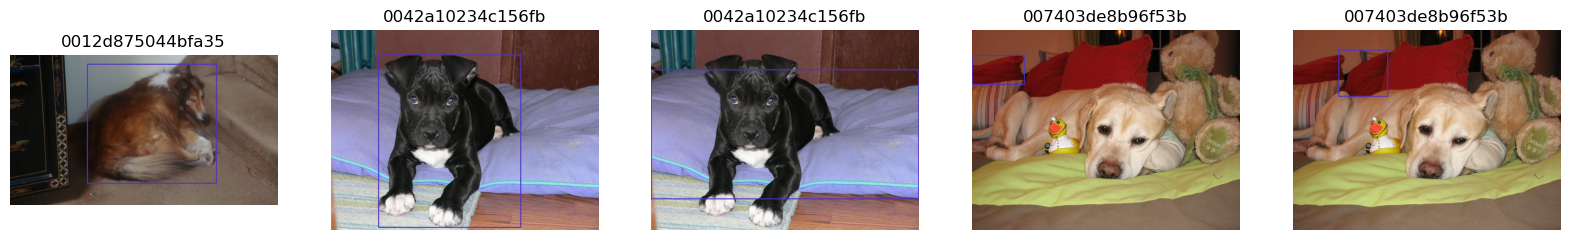

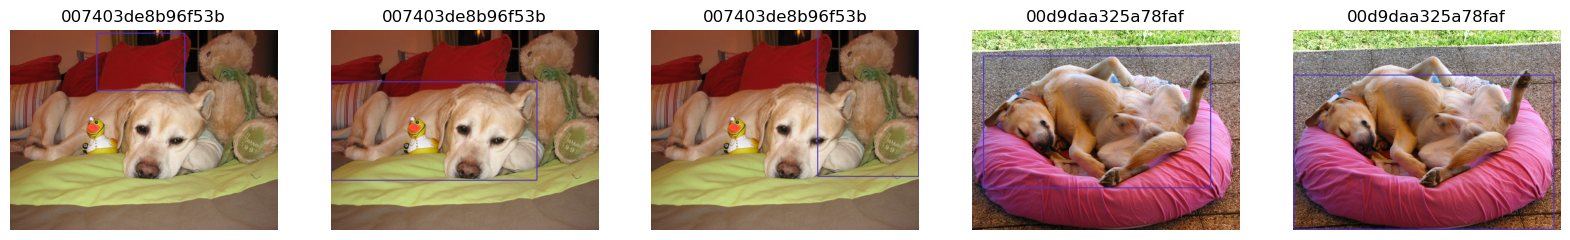

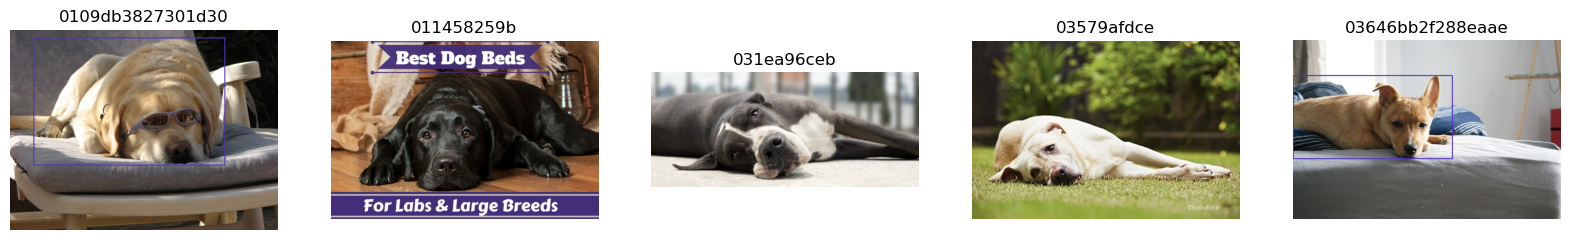

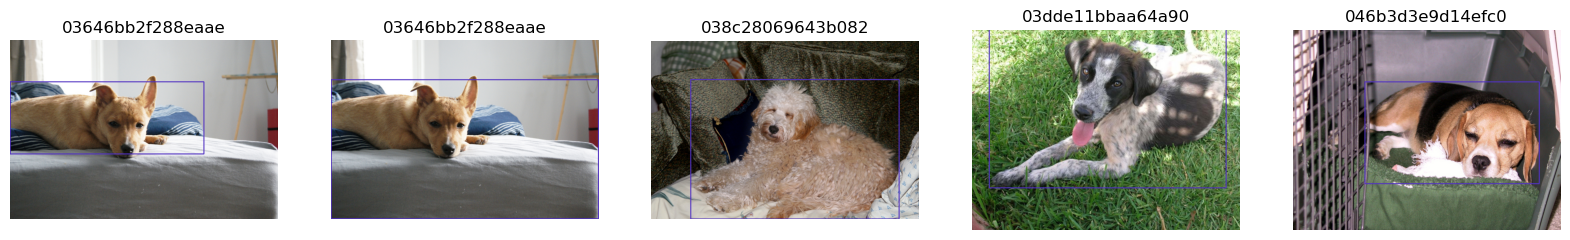

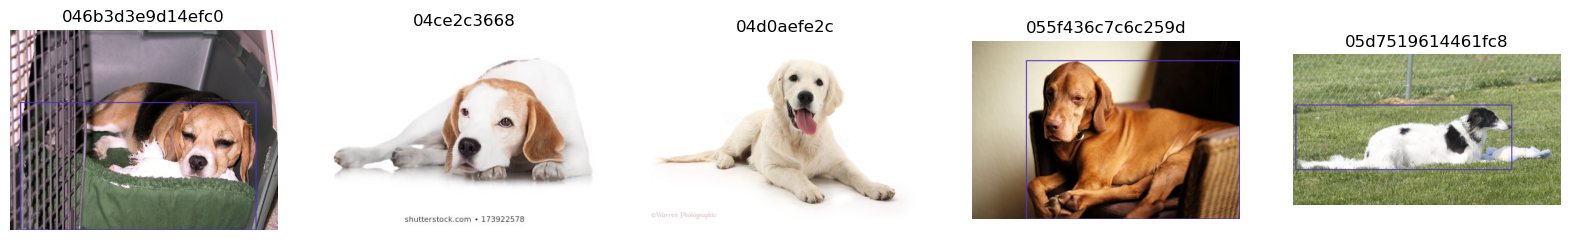

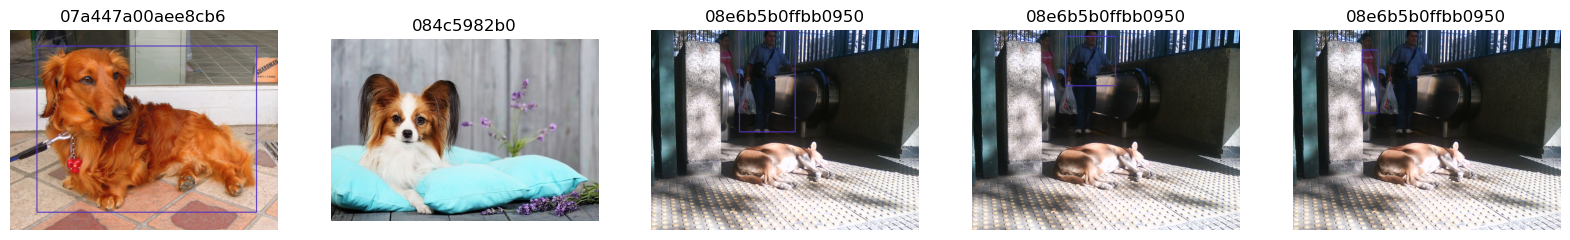

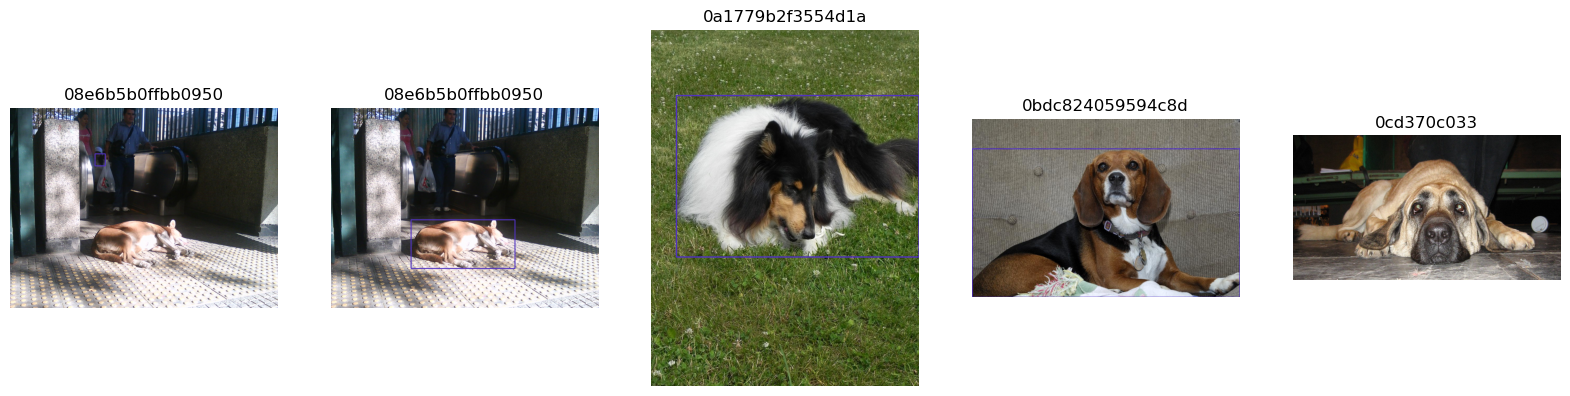

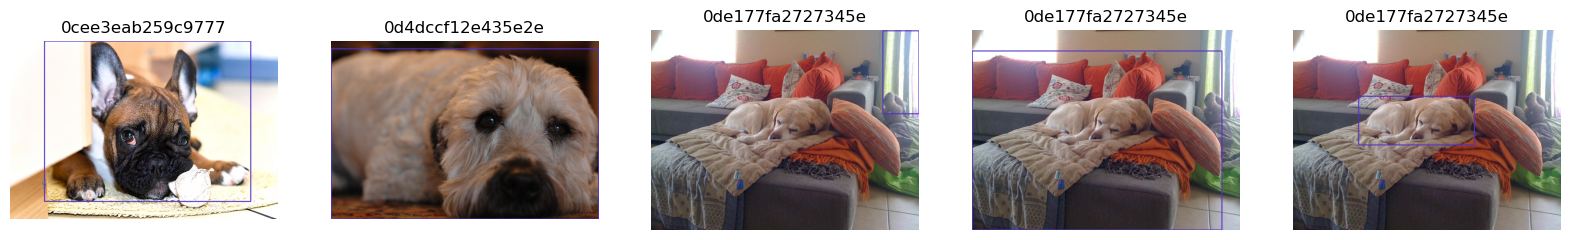

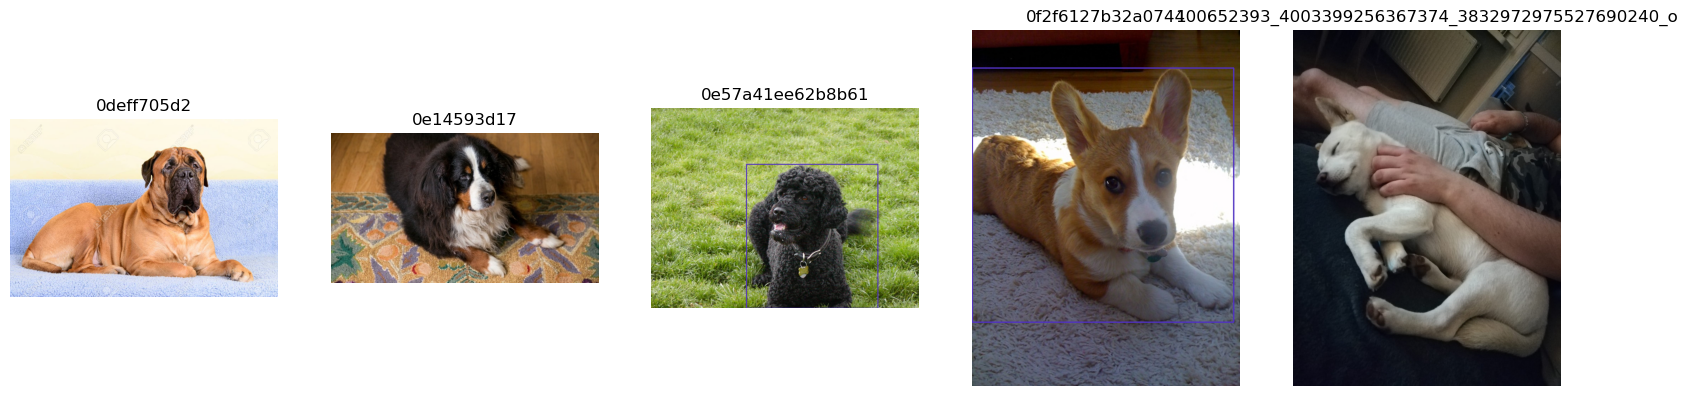

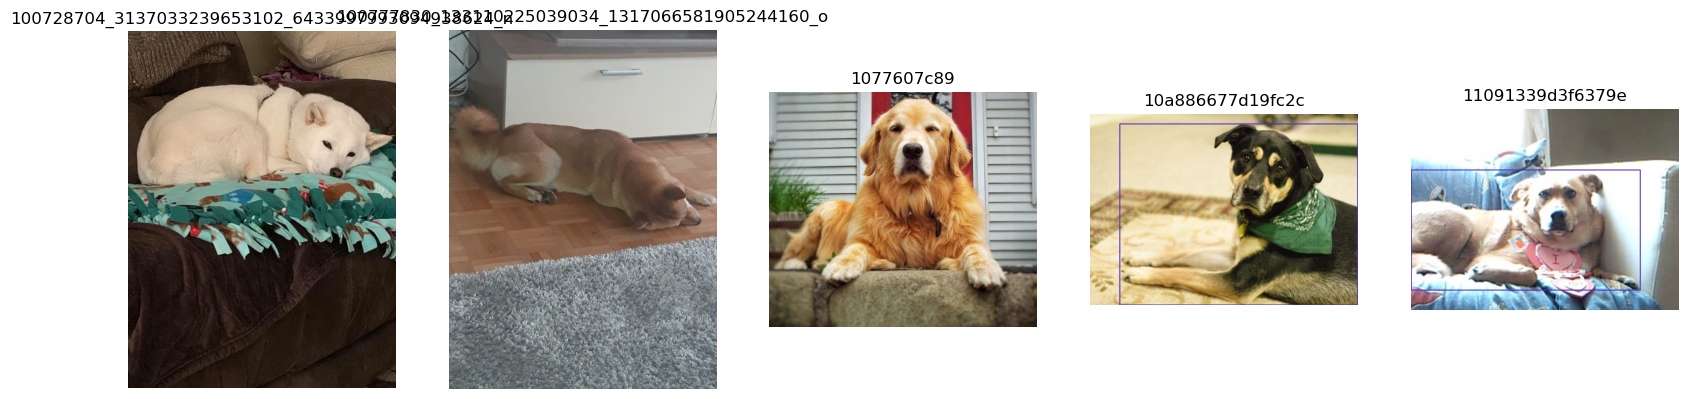

In [29]:
y_min = test.columns.get_loc("YMin")
x_max = test.columns.get_loc("XMax")
x_min = test.columns.get_loc("XMin")
y_max = test.columns.get_loc("YMax")
file = test.columns.get_loc("filename")
clas = test.columns.get_loc("Class")

idx = 0
while idx < 50:
    remaining = min(test.shape[0]-idx, 5)
    fig, ax = plt.subplots(1, remaining, figsize = (20, 20))
    
    for i in range(remaining):
        filepath = os.path.join(files, test.iloc[idx, clas], test.iloc[idx, file]+'.jpg')
        
        I = cv2.imread(filepath)
        I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
        I = draw_bounding_box_on_image(I, 
                                       test.iloc[idx, y_min],
                                       test.iloc[idx, x_min], 
                                       test.iloc[idx, y_max], 
                                       test.iloc[idx, x_max])
        if remaining > 1:
            ax[i].imshow(I.astype("uint8"))
            ax[i].set_title(test.iloc[idx, file])
            ax[i].axis("off")
        else:
            ax.imshow(I.astype("uint8"))
            ax.set_title(test.iloc[idx, file])
            ax.axis("off")
        
        
        idx += 1
    plt.show()

In [30]:

labelMap = pd.read_csv("E:\\dict.csv", header = 0, names = ['Label', 'Description'])
mappings = labelMap.merge(test["LabelName"], left_on = 'Label', right_on = "LabelName", how = 'right')
print(mappings.groupby(['LabelName'], as_index = False).agg({'Description': 'first'}))

      LabelName Description
0     /m/01226z    football
1     /m/0138tl         toy
2     /m/014sv8         eye
3     /m/014y4n      paddle
4     /m/015h_t       beard
..          ...         ...
100     /m/0k4j  automobile
101    /m/0k65p        hand
102    /m/0kmg4  teddy bear
103    /m/0ph39       canoe
104  /m/0wdt60w        None

[105 rows x 2 columns]


In [31]:
#print(DataSet["filename"].unique())
#print(test[test["LabelName"].isnull() | (test['LabelName'] == '/m/0bt9lr')]["filename"].unique())
ymin = test.columns.get_loc("YMin")
xmax = test.columns.get_loc("XMax")
xmin = test.columns.get_loc("XMin")
ymax = test.columns.get_loc("YMax")
y_min = test.columns.get_loc("y_min")
x_max = test.columns.get_loc("x_max")
x_min = test.columns.get_loc("x_min")
y_max = test.columns.get_loc("y_max")


reformat = test.copy()
for idx in range(reformat.shape[0]):
    for y,z in zip([y_min, y_max, x_min, x_max],[ymin, ymax, xmin, xmax]):
        if not pd.isna(reformat.iloc[idx, z]):
            reformat.iloc[idx, y] = reformat.iloc[idx, z]
            

reformat = reformat[reformat["ImageID"].isnull() | (reformat['LabelName'] == '/m/0bt9lr')]
reformat = reformat.drop(reformat.columns[0:21], axis = 1)
display(reformat)
reformat.info()

Class          filename  Height  Width  Channels     y_min  \
0     Lies_on_floor  0012d875044bfa35     576   1024         3  0.068889   
1     Lies_on_floor  0042a10234c156fb     768   1024         3  0.130000   
6     Lies_on_floor  007403de8b96f53b     768   1024         3  0.263333   
8     Lies_on_floor  00d9daa325a78faf     768   1024         3  0.134167   
10    Lies_on_floor  0109db3827301d30     768   1024         3  0.045000   
...             ...               ...     ...    ...       ...       ...   
6545       Standing  feb1e44ba1fb95c1     753   1024         3  0.153912   
6546       Standing  fec100f73ce10a24     680   1024         3  0.104520   
6547       Standing  ffae623038c101f3    1024    768         3  0.196010   
6548       Standing  ffc6f3dfe464c70a     683   1024         3  0.212195   
6550       Standing  ffc7ab8a217d7680     724   1024         3  0.221043   

         x_min     y_max     x_max     score      area  
0     0.288125  0.854444  0.771250  0.901069  0.403205  
1     0.176875  0.985833  0.708125  0.931425  0.451813  
6     0.000000  0.752500  0.769375  0.881868  0.379288  
8     0.042500  0.790000  0.890625  0.861698  0.595367  
10    0.088750  0.676667  0.801875  0.921358  0.496043  
...        ...       ...       ...       ...       ...  
6545  0.131875  0.900510  0.820000  0.709695  0.504217  
6546  0.203877  0.949153  0.807380  0.903280  0.510386  
6547  0.240981  0.828790  0.718027  0.918532  0.299358  
6548  0.291048  0.880722  0.824744  0.905023  0.356641  
6550  0.351875  0.701149  0.942500  0.922997  0.233166  

[4001 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4001 entries, 0 to 6550
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Class     4001 non-null   object 
 1   filename  4001 non-null   object 
 2   Height    4001 non-null   int64  
 3   Width     4001 non-null   int64  
 4   Channels  4001 non-null   int64  
 5   y_min     4001 non-null   float64
 6   x_min     4001 non-null   float64
 7   y_max     4001 non-null   float64
 8   x_max     4001 non-null   float64
 9   score     4001 non-null   float64
 10  area      4001 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 375.1+ KB


In [32]:
reformat['filename'] = reformat.apply(lambda row: row[1] if '.jpg' in row[1] else f"{row[1]}.jpg", axis = 1)
reformat.to_csv("E:\\BBoutput_shiba.csv", index = False)